<div style="text-align: right">INFO 6105 Data Sci Engineering Methods and Tools, Week 3 Lecture 2</div>
<div style="text-align: right">Dino Konstantopoulos, 18 September 2019, with material from Cam Davidson-Pilon</div>

At the end of this lecture, you should a good understanding of how to estimate probabilities for outcomes of different frequency and sample spaces, and how to use Bayes' theorem to answer typical interview questions involving probabilities. You are ready for an introduction to sport analytics.



* * * 
# 5. Introduction to Probability Distributions

<br />
<center>
<img src="http://statistics.wdfiles.com/local--files/ch6/binomial.png" width="400" />
Binomial
</center>

So far, we have made the assumption that every outcome in a sample space (coin toss, die face, balls in urn) is **equally likely**. 

In real life however, we often get outcomes that are **not** equiprobable. For example, the probability of picking a royal in a deck of cards is not the same as the probability of picking a number. The probability of a child being a girl is not exactly 1/2, and the probability is slightly different for a second child. Give a read to this data science [article](http://people.kzoo.edu/barth/math105/moreboys.pdf) that gives the following *counts* for **two-child** families in Denmark, where `GB` means a family where the first child is a girl and the second a boy:

    GG: 121801    GB: 126840
    BG: 127123    BB: 135138
    
That's the number of two-baby births per couple in a year, distribited along the GG, GB, BG, and BB axes.

Because of unequiprobably outcomes (not all urns yield Blue/Red/White balls with equiprobable chances), we need to introduce three more definitions:

* [Frequency](https://en.wikipedia.org/wiki/Frequency_%28statistics%29): a number describing **how often** an outcome occurs. Can be a count like 121801, or a ratio like 0.515.

* [Distribution](http://mathworld.wolfram.com/StatisticalDistribution.html): A **mapping** from outcome to frequency for each possible outcome in a sample space. 

* [Probability Distribution](https://en.wikipedia.org/wiki/Probability_distribution): The distribution above, which has been ***normalized*** so that the sum of the frequencies is 1.

What is a distribution as defined above, in terms of the python container objects we covered in class?

**It's a dictionary structure!!**

Here is an example of a popular probability distribution:
* The **binomial distribution** is frequently used to model the number of successes in a sample of size n drawn **with replacement** from a population of size N. It is parametrized by p and is the discrete probability distribution of the number of `yes`es in a sequence of n independent experiments *with replacement*, each asking a `yes/no` question, and each with its own boolean-valued outcome: a random variable containing a single bit of information: `yes` (with probability p) or `no` (with probability q = 1 − p)
* A single `yes/no` experiment is also called a *Bernoulli trial* or *Bernoulli experiment* and a sequence of outcomes is called a *Bernoulli process*
* For a single trial, i.e., n = 1, the binomial distribution is a **Bernoulli distribution**. 

So now we need to modify our *awesome* probability counting `p()` function to take this *miserable* fact into account.

</p>
<center>
    <img src="ipynb.images/miserable.png" width=200 />
</center>

But first, let's plot a few binomial distributions. This is an *unofficial* introduction to `numpy`'s awesome `matplotlib` package. Also, we use the `scipy` package to import the `binom` function. 

The probability of getting exactly k successes in n trials is given by the probability mass function:

</p>
<center>
    <img src="ipynb.images/binom.png" width=500 />
</center>

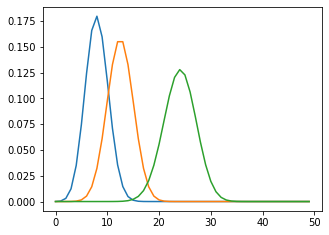

In [2]:
# first, let's plot a few binomial distributions
import numpy as np
from scipy.stats import binom
from matplotlib import pyplot as plt
%matplotlib inline

n_values = [20, 25, 40]
p_values = [0.4, 0.5, 0.6]
x = np.arange(0, 50)

fig, ax = plt.subplots(figsize=(5, 3.75))

for (n, p) in zip(n_values, p_values):
    # create a binomial distribution
    dist = binom(n, p)

    plt.plot(x, dist.pmf(x))

Ok, so let's define `ProbDist`!

We define `ProbDist` to take the same kinds of arguments that dict does: either a mapping or a set of (key, val) pairs, and/or optional keyword arguments (because each ball in the urn will have its own probability of being picked, now!). 

Let's define a Python ***class***, instead of a Python function/lambda. We'll we define constructor `__init__()`. We assume `self` (`this` in Python) is composed of a set:

<div style="display:none;">
class ProbDist(dict):
    """A Probability Distribution; an {outcome: probability} mapping."""
    def __init__(self, mapping=(), **kwargs):
        self.update(mapping, **kwargs)
        # Make probabilities sum to 1.0; assert no negative probabilities
        total = sum(self.values())
        for outcome in self:
            self[outcome] = self[outcome] / total
            assert self[outcome] >= 0
</div>

In [3]:
class ProbDist(dict):
    """A Probability Distribution; an {outcome: probability} mapping."""
    def __init__(self):
        # Make probabilities sum to 1.0; assert no negative probabilities
        total = sum(self.values())
        for outcome in self:
            self[outcome] = self[outcome] / total
            assert self[outcome] >= 0

In [4]:
class ProbDist(dict):
    """A Probability Distribution; an {outcome: probability} mapping."""
    def __init__(self, mapping=(), **kwargs):
        self.update(mapping, **kwargs)
        # Make probabilities sum to 1.0; assert no negative probabilities
        total = sum(self.values())
        for outcome in self:
            self[outcome] = self[outcome] / total
            assert self[outcome] >= 0

We now modify the functions `p` and `such_that` to accept either a sample space as we had previously, ***or a probability distribution as the second argument `space`***. If we have a probability distribution, instead of *counting* each possible outcome equiprobably and thus just summing up `1`s, we need to sum up the different discrete probabilities of each possible outcome: `sum(space[o] for o in space if o in event)`. 

We also need to modify `such_that()`, which is the set of all outcomes of our sample space for which the predicate (first) argument is `True`, so that its second argument can be a `ProbDist`.

We introduce Python's `isinstance` operator, which tells us if a python **object** is of a specific **class**.

In [5]:
def p(event, space): 
    """The probability of an event, given a sample space of outcomes. 
    event: a collection of outcomes, or a predicate that is true of outcomes in the event. 
    space: a set of outcomes or a probability distribution of {outcome: frequency} pairs."""
    
    # if event is a predicate it, "unroll" it as a collection 
    if is_predicate(event):
        event = such_that(event, space)
        
    # if space is not an equiprobably collection (a simple set), 
    # but a probability distribution instead (a dictionary set),
    # then add (union) the probabilities for all favorable outcomes
    if isinstance(space, ProbDist):
        return sum(space[o] for o in space if o in event)
    
    # simplest case: what we played with in our previous lesson
    else:
        return Fraction(len(event & space), len(space))

is_predicate = callable

# Here we either return a simple collection in the case of equiprobable outcomes, or a dictionary collection in the
# case of non-equiprobably outcomes
def such_that(predicate, space): 
    """The outcomes in the sample pace for which the predicate is true.
    If space is a set, return a subset {outcome,...} with outcomes where predicate(element) is true;
    if space is a ProbDist, return a ProbDist {outcome: frequency,...} with outcomes where predicate(element) is true."""
    if isinstance(space, ProbDist):
        return ProbDist({o:space[o] for o in space if predicate(o)})
    else:
        return {o for o in space if predicate(o)}

We used a ***set comprehension***.

Uhhhh... What do we use for sets again in python?

`{}`

To note:
* We are using a python *set* because we care about dictionaries, and dictionary keys are unique
* You can also think in terms of JSON objects

And now we can finally ***take on the Danes***!
<br />
<center>
    <img src="ipynb.images/Danes.png" width=300 />
</center>

Here is the probability distribution for Danish two-child families as a dictionary describing the probability of each possible outcome. It's a **set**, like our urn balls from last lecture, but now it's a ***set of key-value pairs*** instead (a dictionary) because each "ball" (2-child family) has a different probability of being picked (realized)!

In [6]:
DK = ProbDist(GG=121801, GB=126840,
              BG=127123, BB=135138)
DK

{'GG': 0.23840384261560926,
 'GB': 0.24826679089140383,
 'BG': 0.24882071317004043,
 'BB': 0.2645086533229465}

Let's write some useful predicates (lambdas). You write a predicate for each possible yes/no question on something. That is how you convert your thinking into python objects. This is a ***very important step*** in your education as a data scientists/programmer. We started with this last lecture, where you wrote predicates for balls being red, white, or blue. Remember?

```python
def first_girl(outcome):  return outcome[0] == 'G'
def first_boy(outcome):   return outcome[0] == 'B'
def second_girl(outcome): return outcome[1] == 'G'
def second_boy(outcome):  return outcome[1] == 'B'
def two_girls(outcome):   return outcome    == 'GG'
```
Using these predicates, answer the following questions:

* What's the probability for a girl, and is it *higher* or *lower* for a second girl?
* Is the sex of the second child *more likely* or *less likely* to be the same as the first child?

*Hint:* You will leverage `p(first_girl, DK)`, `p(second_girl, DK)`, `p(second_girl, such_that(first_girl, DK))`, and `p(second_girl, such_that(first_boy, DK))`

In [7]:
def first_girl(outcome):  return outcome[0] == 'G'
def first_boy(outcome):   return outcome[0] == 'B'
def second_girl(outcome): return outcome[1] == 'G'
def second_boy(outcome):  return outcome[1] == 'B'
def two_girls(outcome):   return outcome    == 'GG'

In [8]:
p(first_girl, DK)

0.4866706335070131

In [9]:
p(second_girl, DK)

0.4872245557856497

The above says that the probability of a girl is somewhere between 48% and 49%, but that it is *slightly different* between the first or second child.

Now answer the question as to whether the sex of the second child is *more likely* or *less likely* to be the same as the first child, by evaluating first:

- The probability of a second girl given that the first child was a girl (a joint probability)
- The probability of a second girl given that the first child was a boy (a joint probability)
- The probability of a second boy given that the first child was a boy (a joint probability)
- The probability of a second boy given that the first child was a girl (a joint probability)

The average of the first two probabilities above represents the probability of a second girl, a [**marginal probability**](https://en.wikipedia.org/wiki/Marginal_distribution) in our problem.

The avergage of the last two probabilities above represents the probability of a second boy, a **marginal probability** in our problem.

In [10]:
p(second_girl, such_that(first_girl, DK))

0.4898669165584115

In [11]:
p(second_girl, such_that(first_boy, DK))

0.48471942072973107

In [12]:
p(second_boy, such_that(first_girl, DK))

0.5101330834415885

In [13]:
p(second_boy, such_that(first_boy, DK))

0.5152805792702689

The above says that the ***sex of the second child is more likely to be the same as the first child***, by about 1/2 a percentage point.

We find that the probability of a girl is somewhere between 48% and 49%, but slightly different between the first or second child, and that the sex of the second child is more likely to be the same as the first child, by about 1/2 a percentage point.

We've now began to work with **probability distributions**, which is nothing else than ***dictionaries***, where each key (outcome) had a different probability of occurring (value).

# 6. M&Ms and Bayes
<br />
<center>
<img src="https://upload.wikimedia.org/wikipedia/en/9/97/M%26M_spokescandies.jpeg" />
</center>

Here's another classic urn problem (or "bag" problem) [from](http://allendowney.blogspot.com/2011/10/my-favorite-bayess-theorem-problems.html) prolific Python/Probability author [Allen Downey ](http://allendowney.blogspot.com/), which also happens to be a classic interview question:

> The blue M&M was introduced in 1995.  Before then, the color mix in a bag of plain M&Ms was (30% Brown, 20% Yellow, 20% Red, 10% Green, 10% Orange, 10% Tan).  Afterward it was (24% Blue , 20% Green, 16% Orange, 14% Yellow, 13% Red, 13% Brown). 
A friend of mine has two bags of M&Ms, and he tells me that one is from 1994 and one from 1996.  He won't tell me which is which, but he gives me one M&M from each bag.  One is yellow and one is green.  What is the probability that the yellow M&M came from the 1994 bag? Well, the old M&M bags' yellow count was higher, so it must be higher, right? But how to count?

To solve this problem, we'll first represent probability distributions for each bag: `bag94` and `bag96`, by using `ProbDist` and passing in dictionaries for each year:
```python
bag94 = ProbDist(brown=30, yellow=20, red=20, green=10, orange=10, tan=10)
bag96 = ProbDist(...)  #fill this in, please
```

In [14]:
bag94 = ProbDist(brown=30, yellow=20, red=20, green=10, orange=10, tan=10)

In [15]:
bag96 = ProbDist(brown=13, yellow=14, red=13, green=20, orange=16, blue=24)

In [16]:
len(bag94)
bag94

{'brown': 0.3,
 'yellow': 0.2,
 'red': 0.2,
 'green': 0.1,
 'orange': 0.1,
 'tan': 0.1}

Next, define `MM` as the *joint* distribution 94-96&mdash;the sample space for picking *one* M&M from *each* bag. The outcome `'yellow green'` means that a yellow M&M was selected from the 1994 bag and a green one from the 1996 bag. This is very similar to our `cross` function from last lecture, except now we're working with python *dictionaries*.

```python
def joint(A, B, sep=''):
    """The joint distribution of two independent probability distributions. 
    Result is all entries of the form {a+sep+b: P(a)*P(b)}"""
    return ProbDist({a + sep + b: A[a] * B[b]
                    for ...
                    for ...})

MM = joint(bag94, bag96, ' ')
MM
```

In [17]:
def joint(A, B, sep=''):
    """The joint distribution of two independent probability distributions. 
    Result is all entries of the form {a+sep+b: P(a)*P(b)}"""
    return ProbDist({a + sep + b: A[a] * B[b]
                    for a in A
                    for b in B
                                        })

MM = joint(bag94, bag96, ' ')
MM

{'brown brown': 0.038999999999999986,
 'brown yellow': 0.04199999999999998,
 'brown red': 0.038999999999999986,
 'brown green': 0.05999999999999997,
 'brown orange': 0.04799999999999998,
 'brown blue': 0.07199999999999997,
 'yellow brown': 0.025999999999999992,
 'yellow yellow': 0.02799999999999999,
 'yellow red': 0.025999999999999992,
 'yellow green': 0.03999999999999999,
 'yellow orange': 0.03199999999999999,
 'yellow blue': 0.04799999999999998,
 'red brown': 0.025999999999999992,
 'red yellow': 0.02799999999999999,
 'red red': 0.025999999999999992,
 'red green': 0.03999999999999999,
 'red orange': 0.03199999999999999,
 'red blue': 0.04799999999999998,
 'green brown': 0.012999999999999996,
 'green yellow': 0.013999999999999995,
 'green red': 0.012999999999999996,
 'green green': 0.019999999999999993,
 'green orange': 0.015999999999999993,
 'green blue': 0.02399999999999999,
 'orange brown': 0.012999999999999996,
 'orange yellow': 0.013999999999999995,
 'orange red': 0.012999999999999

Let's look at the "One is yellow and one is green" part:

```python
def yellow_and_green(outcome): return 'yellow' in outcome and 'green' in outcome

such_that(...) # fill this in
```

In [18]:
def yellow_and_green(outcome): return 'yellow' in outcome and 'green' in outcome

such_that(yellow_and_green,MM)

{'yellow green': 0.7407407407407408, 'green yellow': 0.25925925925925924}

Now we can answer the question: given that we got a **yellow** and a **green** (but don't know which comes from which bag), what is the probability that the ***yellow came from the 1994 bag***?

```python
def yellow94(outcome): return ...

p(yellow94, such_that(...)) # fill this in
```

In [19]:
def yellow94(outcome): return outcome.startswith('yellow')

p(yellow94, such_that(yellow_and_green,MM))

0.7407407407407408

So there is a 74% chance that the yellow comes from the 1994 bag. We were *right* about our hunch :-)

Answering this question was straightforward: just like all the other probability problems, we simply create a sample space, and use `p` to pick out the probability of the event in question, given what we know about the outcome. This is the 'mechanistic' way of obtaining our answer.

We can *also* solve it using *Bayes' Theorem*, and this is as good as any's introduction to **naive Bayes theory**: We are asked about the probability of an event (M&M94 --> M&M96) *given the evidence* (M&M94 is yellow, M&M96 green), which is not immediately available. However the probability of the evidence, given the event (***the inverse!***) is readily available!  

Before we see the colors of the M&Ms, there are two hypotheses, `A` and `B`, both with equal probability:

    A: first M&M from 94 bag, second from 96 bag
    B: first M&M from 96 bag, second from 94 bag
    P(A) = P(B) = 0.5
    
Then we get some evidence:
    
    E: first M&M yellow, second green
    
We want to know the probability of hypothesis `A`, given the evidence:
    
    P(A | E)
    
That's not easy to calculate (except by enumerating the sample space with python and a laptop, which is what we did above). But Bayes Theorem says:
    
    P(A | E) = P(E | A) * P(A) / P(E)
    
The quantities on the *right-hand-side* are easier to calculate:
    
    P(E | A) = 20/100 * 20/100 = 0.04
    P(E | B) = 10/100 * 14/100 = 0.014
    P(A)     = 0.5
    P(B)     = 0.5
    P(E)     = P(E | A) * P(A) + P(E | B) * P(B) 
             = 0.04     * 0.5  + 0.014    * 0.5   =   0.027
             
Where did the probability of the evidence P(E) formula come from?

There are two possibilities of getting the evidence: A and B, a *union* and so we sum their probabilities. The joint probability of the evidence *and* case A is a succession or *intersection*, so it must be a product of their probabilities: P(E|A).P(A). Likewise for the case B: P(E|B).P(B) 
    
And so we can get a final answer:
    
    P(A | E) = P(E | A) * P(A) / P(E) 
             = 0.04     * 0.5  / 0.027 
             = 0.7407407407
             
Bayes Theorem allows you to do less calculation at the cost of more algebra; that is a great trade-off if you are working with pencil and paper (like in ***interview situations!!!***). Enumerating the state space allows you to do less algebra at the cost of more calculation; often a good trade-off if you have a computer. 

Regardless of the approach you use, it is important to understand Bayes theorem and how it works.

# Conclusion¶
We've built a framework for estimating **probabilities** that will come in handy when you are asked to build **data models**. 

We played with Bayes' theorem, a pillar of data science, and we started learning how to answer typical Data Science interview questions, which you should *always* answer in python because you *will* run out of space on the whiteboard if you use squiggly brackets in other languages! 

Next week, we move on to statistical modeling and inference. **Modeling** (one `l` or 2 `l`s? See [here](https://www.grammarly.com/blog/modeling-or-modelling/)) happens when data is scarce and precious and hard to obtain, for example in social sciences and settings where it is difficult to conduct large-scale controlled experiments. With small data it is important to quantify uncertainty and that’s precisely what Bayesian approaches are good at. **Inference** refers to how you learn parameters of your model (Markov Chain Monte Carlo, or MCMC, albeit computationally expensive, is one of the most important methods for statistical inference), which is especially important with Bayesian Machine Learning, where we can actually inquire with Machines why this or that action was undertaken.

*Alexa, why did you lower the temperature in the bedroom?* **Because your wife told me that whenever you start snoring, John, colder tempreatures make you bundle up under the cover and you snore less**. 

<br />
<center>
    <img src="ipynb.images/echo.jpg" width=200 />
</center>

Best advice for interviews: Be explicit about what the problem says, have the interviewer verify the working hypotheses, be methodical about defining the sample space, be careful in counting the number of outcomes in the numerator and denominator, and finally use Bayes' theorem (or 1 minus the negation) whenever possible because you will be doing calculations by hand on a whiteboard!

<br />
<center>
    <img src="ipynb.images/jobinterview.jpg" width=300 />
</center>

# Homework: Introduction to Data Science for Sports

<br />
<center>
    <img src="ipynb.images/f1races.png" width=800 />
</center>

Question 1.1 (20 points) There are a number of F1 races coming up: 
- Singapore GP: Date: Sun, Sep 22, 8:10 AM
- Russian GP: Date: Sun, Sep 29, 7:10 AM
- Japanese GP: Date: Sun, Oct 13, 1:10 AM
- Mexican GP Date: Sun, Oct 13, 1:10 AM

The Singaporean Grand Prix this weekend and the Russian Grand Prix the weekend after, as you can see [here](https://www.formula1.com/en/racing/2019.html). 

The 2019 driver standings are given [here](https://www.formula1.com/en/results.html/2019/drivers.html). Given these standings (please do not use team standings given onthe same Web site, use driver standings), what is the Probability Distribution for each F1 driver to win the Singaporean Grand Prix? What is the Probability Distribution for each F1 driver to win *both* the Singaporean and Russian Grand Prix? What is the probability for Mercedes to win both races? What is the probability for Mercedes to win at least one race? Note that Mercedes, and each other racing team, has two drivers per race.

Question 1.2 (30 points) If Mercedes wins the first race, what is the probability that Mercedes wins the next one? If Mercedes wins at least one of these two races, what is the probability Mercedes wins both races? How about Ferrari, Red Bull, and Renault?

Question 1.3 (50 points) Mercedes wins one of these two races on a **rainy** day. What is the probability Mercedes wins both races, assuming races can be held on either rainy, sunny, cloudy, snowy or foggy days? Assume that rain, sun, clouds, snow, and fog are the *only possible weather conditions* on race tracks.

You need to provide *proof* for your answers. `I think it's one in a million because Mercedes sucks and I like Ferrari a lot more` is not a good answer. Leverage the counting framework in this workbook!

Hint: Use SingaporeanGrandPrix, or `SGP` to denote the Probability Distribution given by F1 driver wins. Write driver initials as keys and driver wins as values in a dictionary that you pass to our function `ProbDist`..

### Question 1

# 1.1 Probability Distribution for each F1 driver to win the Singaporean Grand Prix

In [20]:
#Q-1.1 Probability Distribution for each F1 driver to win the Singaporean Grand Prix
SGP = ProbDist(
    LH = 284,VB=221,MV=185,CL=182,SV=169,PG=65,CS=58,DR=34,AA=34,DK=33,NH=31,KR=31,SP=27,LN=25,LS=19,KM=18,RG=8,AG=3,RK=1,GR=0)
SGP

{'LH': 0.19887955182072828,
 'VB': 0.15476190476190477,
 'MV': 0.12955182072829133,
 'CL': 0.12745098039215685,
 'SV': 0.11834733893557423,
 'PG': 0.04551820728291316,
 'CS': 0.04061624649859944,
 'DR': 0.023809523809523808,
 'AA': 0.023809523809523808,
 'DK': 0.023109243697478993,
 'NH': 0.021708683473389355,
 'KR': 0.021708683473389355,
 'SP': 0.018907563025210083,
 'LN': 0.01750700280112045,
 'LS': 0.01330532212885154,
 'KM': 0.012605042016806723,
 'RG': 0.0056022408963585435,
 'AG': 0.0021008403361344537,
 'RK': 0.0007002801120448179,
 'GR': 0.0}

In [21]:
RGP = ProbDist(
    LH = 284,VB=221,MV=185,CL=182,SV=169,PG=65,CS=58,DR=34,AA=34,DK=33,NH=31,KR=31,SP=27,LN=25,LS=19,KM=18,RG=8,AG=3,RK=1,GR=0)
RGP

{'LH': 0.19887955182072828,
 'VB': 0.15476190476190477,
 'MV': 0.12955182072829133,
 'CL': 0.12745098039215685,
 'SV': 0.11834733893557423,
 'PG': 0.04551820728291316,
 'CS': 0.04061624649859944,
 'DR': 0.023809523809523808,
 'AA': 0.023809523809523808,
 'DK': 0.023109243697478993,
 'NH': 0.021708683473389355,
 'KR': 0.021708683473389355,
 'SP': 0.018907563025210083,
 'LN': 0.01750700280112045,
 'LS': 0.01330532212885154,
 'KM': 0.012605042016806723,
 'RG': 0.0056022408963585435,
 'AG': 0.0021008403361344537,
 'RK': 0.0007002801120448179,
 'GR': 0.0}

# 1.1 Probability Distribution for each F1 driver to win both the Singaporean and Russian Grand Prix

In [22]:
#Q-1.1 Probability Distribution for each F1 driver to win both the Singaporean and Russian Grand Prix
NN = joint(SGP,RGP,'')
NN

{'LHLH': 0.03955307613241369,
 'LHVB': 0.03077897825796981,
 'LHMV': 0.02576520804400188,
 'LHCL': 0.025347393859504547,
 'LHSV': 0.023536865726682798,
 'LHPG': 0.009052640664108767,
 'LHCS': 0.00807774090028167,
 'LHDR': 0.004735227424303048,
 'LHAA': 0.004735227424303048,
 'LHDK': 0.004595956029470606,
 'LHNH': 0.0043174132398057195,
 'LHKR': 0.0043174132398057195,
 'LHSP': 0.0037603276604759495,
 'LHLN': 0.0034817848708110647,
 'LHLS': 0.002646156501816409,
 'LHKM': 0.0025068851069839663,
 'LHRG': 0.0011141711586595408,
 'LHAG': 0.00041781418449732776,
 'LHRK': 0.0001392713948324426,
 'LHGR': 0.0,
 'VBLH': 0.03077897825796981,
 'VBVB': 0.02395124716553285,
 'VBMV': 0.020049686541283154,
 'VBCL': 0.019724556489262343,
 'VBSV': 0.018315659597172178,
 'VBPG': 0.007044484460450837,
 'VBCS': 0.006285847672402286,
 'VBDR': 0.003684807256235823,
 'VBAA': 0.003684807256235823,
 'VBDK': 0.003576430572228887,
 'VBNH': 0.003359677204215015,
 'VBKR': 0.003359677204215015,
 'VBSP': 0.00292617046

# Cars Dictionary for both the SGP and RGP

In [23]:

cars_SGP = ProbDist(MR=505,RB=219,FR=351,RH=98,MCR=83,RE=65,ARF=34,PMERS=46,HF=26,WMER=1)
cars_RGP = ProbDist(MR=505,RB=219,FR=351,RH=98,MCR=83,RE=65,ARF=34,PMERS=46,HF=26,WMER=1)


MMRR=joint(cars_SGP,cars_RGP,' ')
MMRR


{'MR MR': 0.12506227981388646,
 'MR RB': 0.05423492926582403,
 'MR FR': 0.08692447567262207,
 'MR RH': 0.024269511726259154,
 'MR MCR': 0.020554790543668468,
 'MR RE': 0.01609712512455964,
 'MR ARF': 0.008420034680538889,
 'MR PMERS': 0.011391811626611438,
 'MR HF': 0.006438850049823858,
 'MR WMER': 0.00024764807883937914,
 'RB MR': 0.05423492926582403,
 'RB RB': 0.02351970199844646,
 'RB FR': 0.037695960737236106,
 'RB RH': 0.01052479815455595,
 'RB MCR': 0.008913859661511673,
 'RB RE': 0.006980733469858538,
 'RB ARF': 0.0036514605842336966,
 'RB PMERS': 0.0049402113786691185,
 'RB HF': 0.0027922933879434156,
 'RB WMER': 0.0001073958995362852,
 'FR MR': 0.08692447567262207,
 'FR RB': 0.037695960737236106,
 'FR FR': 0.06041681378433731,
 'FR RH': 0.01686851211072666,
 'FR MCR': 0.014286596991737883,
 'FR RE': 0.011188298848951355,
 'FR ARF': 0.005852340936374554,
 'FR PMERS': 0.007917873031565574,
 'FR HF': 0.004475319539580543,
 'FR WMER': 0.00017212767459925162,
 'RH MR': 0.024269511

# 1.1 Probability for Mercedes to win both races

In [24]:
#Q-1.1 Probability for Mercedes to win both races

def first_MR(outcome):  return outcome.split(' ')[0] == 'MR'

def second_MR(outcome):  return outcome.split(' ')[1] == 'MR'

def first_MR_and_second_MR(outcome): return outcome=='MR MR'

bothMR=p(first_MR_and_second_MR,MMRR)
print("Probability for Mercedes to win both races:",bothMR)

Probability for Mercedes to win both races: 0.12506227981388646


# 1.1 Probability for Mercedes to win at least one race

In [25]:
#Q-1.1 Probability for Mercedes to win at least one race
def MRwinone(outcome): return outcome.split(' ')[0] == 'MR' or outcome.split(' ')[1] == 'MR'

atleastoneMR =p(MRwinone,MMRR)
print("Probability for Mercedes to win at least one race:",atleastoneMR)


Probability for Mercedes to win at least one race: 0.5822206333513802


# 1.2 If Mercedes wins the first race, what is the probability that Mercedes wins the next one

In [26]:
#Q-1.2 If Mercedes wins the first race, what is the probability that Mercedes wins the next one

endsMRvar=p(second_MR,such_that(first_MR,MMRR))
print("Probability that Mercedes wins the next one:",endsMRvar)

Probability that Mercedes wins the next one: 0.3536414565826331


# 1.2 If Mercedes wins at least one of these two races, what is the probability Mercedes wins both races

In [27]:
#Q-1.2 If Mercedes wins at least one of these two races, what is the probability Mercedes wins both races
#MErcedes win Both Races
def MRwinone(outcome): return outcome.split(' ')[0] == 'MR' or outcome.split(' ')[1] == 'MR'

def MRwinboth(outcome): return outcome.split(' ')[0] == 'MR' and outcome.split(' ')[1] == 'MR'

MRwinsBoth = p(MRwinboth,such_that(MRwinone,MMRR))
print("Probability Mercedes wins both races:",MRwinsBoth)

Probability Mercedes wins both races: 0.21480221182475548


# 1.2  How about Ferrari, Red Bull, and Renault

In [28]:
#Q-1.2  How about Ferrari, Red Bull, and Renault
#Ferrari
def FRwinone(outcome): return outcome.split(' ')[0] == 'FR' or outcome.split(' ')[1] == 'FR'

def FRwinboth(outcome): return outcome.split(' ')[0] == 'FR' and outcome.split(' ')[1] == 'FR'

FRwinsBoth = p(FRwinboth,such_that(FRwinone,MMRR))
print("Probability Ferrari wins both races:",FRwinsBoth)

#Red Bull
def RBwinone(outcome): return outcome.split(' ')[0] == 'RB' or outcome.split(' ')[1] == 'RB'

def RBwinboth(outcome): return outcome.split(' ')[0] == 'RB' and outcome.split(' ')[1] == 'RB'

RBwinsBoth = p(RBwinboth,such_that(RBwinone,MMRR))
print("Probability Red Bull wins both races:",RBwinsBoth)

#Renault
def REwinone(outcome): return outcome.split(' ')[0] == 'RE' or outcome.split(' ')[1] == 'RE'

def REwinboth(outcome): return outcome.split(' ')[0] == 'RE' and outcome.split(' ')[1] == 'RE'

REwinsBoth = p(REwinboth,such_that(REwinone,MMRR))
print("Probability Red Bull wins both races:",REwinsBoth)


Probability Ferrari wins both races: 0.14011976047904195
Probability Red Bull wins both races: 0.08304891922639362
Probability Red Bull wins both races: 0.023289143676101756


# 1.3 Mercedes wins one of these two races on a rainy day. What is the probability Mercedes wins both races, 
Assuming races can be held on either rainy, sunny, cloudy, snowy or foggy days? 
Assume that rain, sun, clouds, snow, and fog are the only possible weather conditions on race tracks.

In [29]:
#Q-1.3 Mercedes wins one of these two races on a rainy day. What is the probability Mercedes wins both races, 
#assuming races can be held on either rainy, sunny, cloudy, snowy or foggy days? 
#Assume that rain, sun, clouds, snow, and fog are the only possible weather conditions on race tracks.


Weather=ProbDist(R=0.2,S=0.2,C=0.2,SN=0.2,F=0.2)
Weather

{'R': 0.2, 'S': 0.2, 'C': 0.2, 'SN': 0.2, 'F': 0.2}

In [30]:
Cars_SGPWe = joint(cars_SGP,Weather,'')
Cars_SGPWe

{'MRR': 0.07072829131652666,
 'MRS': 0.07072829131652666,
 'MRC': 0.07072829131652666,
 'MRSN': 0.07072829131652666,
 'MRF': 0.07072829131652666,
 'RBR': 0.030672268907563045,
 'RBS': 0.030672268907563045,
 'RBC': 0.030672268907563045,
 'RBSN': 0.030672268907563045,
 'RBF': 0.030672268907563045,
 'FRR': 0.049159663865546245,
 'FRS': 0.049159663865546245,
 'FRC': 0.049159663865546245,
 'FRSN': 0.049159663865546245,
 'FRF': 0.049159663865546245,
 'RHR': 0.01372549019607844,
 'RHS': 0.01372549019607844,
 'RHC': 0.01372549019607844,
 'RHSN': 0.01372549019607844,
 'RHF': 0.01372549019607844,
 'MCRR': 0.011624649859943985,
 'MCRS': 0.011624649859943985,
 'MCRC': 0.011624649859943985,
 'MCRSN': 0.011624649859943985,
 'MCRF': 0.011624649859943985,
 'RER': 0.009103641456582639,
 'RES': 0.009103641456582639,
 'REC': 0.009103641456582639,
 'RESN': 0.009103641456582639,
 'REF': 0.009103641456582639,
 'ARFR': 0.004761904761904765,
 'ARFS': 0.004761904761904765,
 'ARFC': 0.004761904761904765,
 'ARFS

In [31]:
Cars_RGPWe = joint(cars_RGP,Weather,'')
Cars_RGPWe

{'MRR': 0.07072829131652666,
 'MRS': 0.07072829131652666,
 'MRC': 0.07072829131652666,
 'MRSN': 0.07072829131652666,
 'MRF': 0.07072829131652666,
 'RBR': 0.030672268907563045,
 'RBS': 0.030672268907563045,
 'RBC': 0.030672268907563045,
 'RBSN': 0.030672268907563045,
 'RBF': 0.030672268907563045,
 'FRR': 0.049159663865546245,
 'FRS': 0.049159663865546245,
 'FRC': 0.049159663865546245,
 'FRSN': 0.049159663865546245,
 'FRF': 0.049159663865546245,
 'RHR': 0.01372549019607844,
 'RHS': 0.01372549019607844,
 'RHC': 0.01372549019607844,
 'RHSN': 0.01372549019607844,
 'RHF': 0.01372549019607844,
 'MCRR': 0.011624649859943985,
 'MCRS': 0.011624649859943985,
 'MCRC': 0.011624649859943985,
 'MCRSN': 0.011624649859943985,
 'MCRF': 0.011624649859943985,
 'RER': 0.009103641456582639,
 'RES': 0.009103641456582639,
 'REC': 0.009103641456582639,
 'RESN': 0.009103641456582639,
 'REF': 0.009103641456582639,
 'ARFR': 0.004761904761904765,
 'ARFS': 0.004761904761904765,
 'ARFC': 0.004761904761904765,
 'ARFS

In [32]:
 SGP_RGP_Weather= joint(Cars_SGPWe,Cars_RGPWe,' ')
SGP_RGP_Weather

{'MRR MRR': 0.005002491192555535,
 'MRR MRS': 0.005002491192555535,
 'MRR MRC': 0.005002491192555535,
 'MRR MRSN': 0.005002491192555535,
 'MRR MRF': 0.005002491192555535,
 'MRR RBR': 0.0021693971706329943,
 'MRR RBS': 0.0021693971706329943,
 'MRR RBC': 0.0021693971706329943,
 'MRR RBSN': 0.0021693971706329943,
 'MRR RBF': 0.0021693971706329943,
 'MRR FRR': 0.003476979026904935,
 'MRR FRS': 0.003476979026904935,
 'MRR FRC': 0.003476979026904935,
 'MRR FRSN': 0.003476979026904935,
 'MRR FRF': 0.003476979026904935,
 'MRR RHR': 0.0009707804690503809,
 'MRR RHS': 0.0009707804690503809,
 'MRR RHC': 0.0009707804690503809,
 'MRR RHSN': 0.0009707804690503809,
 'MRR RHF': 0.0009707804690503809,
 'MRR MCRR': 0.0008221916217467512,
 'MRR MCRS': 0.0008221916217467512,
 'MRR MCRC': 0.0008221916217467512,
 'MRR MCRSN': 0.0008221916217467512,
 'MRR MCRF': 0.0008221916217467512,
 'MRR RER': 0.0006438850049823955,
 'MRR RES': 0.0006438850049823955,
 'MRR REC': 0.0006438850049823955,
 'MRR RESN': 0.00064

In [34]:
def WeatherMRR_SGP(outcome):  return outcome.split(' ')[0] == 'MRR'

def WeatherMRR_RGP(outcome):  return outcome.split(' ')[1] == 'MRR' or outcome.split(' ')[1] == 'MRS' or outcome.split(' ')[1] == 'MRC' or outcome.split(' ')[1] == 'MRSN' or outcome.split(' ')[1] == 'MRF'

MRBothRaces =p(WeatherMRR_RGP,such_that(WeatherMRR_SGP,SGP_RGP_Weather))
print("Probability Mercedes wins both races:",MRBothRaces)




Probability Mercedes wins both races: 0.35364145658263324
